###Imports

In [1]:
import torch
import time
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
import pandas as pd
import numpy as np
!pip install transformers==3.3.1
from transformers import AutoModel, AutoTokenizer
from torch import cuda
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from torch.utils.data import Dataset,DataLoader
from transformers import AdamW,get_linear_schedule_with_warmup
import time
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report,confusion_matrix
import re
from nltk.corpus import words
from bs4 import BeautifulSoup
import nltk
nltk.download('words')
import nltk, string, re, spacy,unicodedata, random
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import ToktokTokenizer
import nltk, string, re, spacy,unicodedata, random
from numpy import asarray
from numpy import zeros

     |████████████████████████████████| 1.1MB 8.0MB/s 
     |████████████████████████████████| 1.2MB 27.4MB/s 
     |████████████████████████████████| 901kB 52.0MB/s 
     |████████████████████████████████| 3.0MB 51.3MB/s 
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Import Preprocessed Csv

In [3]:
train = pd.read_csv('/content/drive/MyDrive/TASME/data/tamil_offensive_full_train.csv', names=['text','label','nan'])
train = train.drop(columns=['nan'])
train = train.dropna()
train.label = train.label.apply({'Not_offensive':0,'Offensive_Untargetede':1,'Offensive_Targeted_Insult_Group':2,'Offensive_Targeted_Insult_Individual':3,'not-Tamil':4, 'Offensive_Targeted_Insult_Other':5}.get)
train

,text,label
0,movie vara level la Erika poguthu,0
1,I love Ajith Kumar Vivegam movie inki mjy bht ...,4
2,Padam nalla comedy padama irukum polaye..,0
3,karthick subburaj anne .... intha padam vetri ...,0
4,கவுண்டர் தேவர்.சார்பாக வெற்றி பெற வாழ்த்துக்கள் 🦁,0
...,...,...
35134,Trending number #2 idhukku nammalam karanamnu ...,0
35135,"Movie script super, athuvum HIP HOP Tamizha mu...",0
35136,Just 3k likes for 300k likes,0
35137,Aaloo le lo. Kanda le lo.,4


In [5]:
print(train['text'][672])

Inda music ha engaiyoo keta mariyae irukae??🤔🤔🤔


In [6]:
val = pd.read_csv('/content/drive/MyDrive/TASME/data/tamil_offensive_full_dev.csv', names=['text','label','nan'])
val = val.drop(columns=['nan'])
val = val.dropna()
val.label = val.label.apply({'Not_offensive':0,'Offensive_Untargetede':1,'Offensive_Targeted_Insult_Group':2,'Offensive_Targeted_Insult_Individual':3,'not-Tamil':4, 'Offensive_Targeted_Insult_Other':5}.get)
val

,text,label
0,Handsome hunk keri vaa thalaivaa,0
1,தென்காசி மாவட்டம் நாடார் சமுதாயம் சார்பாக வாழ்...,0
2,je vous aime bravo pour clip de merde que j éc...,4
3,சிறப்பு..... மேலும் இது போன்ற படைப்புகள் மிக அ...,0
4,Vera level BGM .. semma trailer. 🤞,0
...,...,...
4383,மிஷ்கின் - சினிமாவின் சலித்து போன வட்டத்திற்க...,0
4384,Sivaji - Bhajii Sapdu Petta - Sweet Sapdu Ser...,0
4385,8k dislike sure all vijay fans,5
4386,Lady super star Manju warrier Fans Hit like,0


In [7]:
test = pd.read_csv('/content/drive/MyDrive/TASME/data/tamil_offensive_full_test_with_labels.csv', names=['text', 'label'])
test.label = test.label.apply({'Not_offensive':0,'Offensive_Untargetede':1,'Offensive_Targeted_Insult_Group':2,'Offensive_Targeted_Insult_Individual':3,'not-Tamil':4, 'Offensive_Targeted_Insult_Other':5}.get)
test = test.dropna()
test

,text,label
0,14.12.2018 epo trailer pathutu irken ... Semay...,0
1,Paka thana poro movie la Enna irukunu,0
2,“U kena tunggu lebih lama lagi untuk tahu saya...,4
3,Suriya anna vera level anna mass,0
4,suma kaththaatha da sound over a pooda kudaath...,1
...,...,...
4387,மண்ணு பொண்ணு ரெண்டுமே ஒன்னு அதுல எவன் கைய வச்ச...,2
4388,Babu mele ko ye song sunke kuch yesa feel hua ...,4
4389,asuran= aadukalam+pudupettai+ wada chennai..ye...,0
4390,Vijay's all movies look like same.,0


###Preprocessing

In [8]:
def deEmojify(string):
  emoji_pattern = re.compile("["
                              u"\U0001F600-\U0001F64F"  # emoticons
                              u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                              u"\U0001F680-\U0001F6FF"  # transport & map symbols
                              u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                              u"\U00002500-\U00002BEF"  # chinese char
                              u"\U00002702-\U000027B0"
                              u"\U00002702-\U000027B0"
                              u"\U000024C2-\U0001F251"
                              u"\U0001f926-\U0001f937"
                              u"\U00010000-\U0010ffff"
                              u"\u2640-\u2642"
                              u"\u2600-\u2B55"
                              u"\u200d"
                              u"\u23cf"
                              u"\u23e9"
                              u"\u231a"
                              u"\ufe0f"  # dingbats
                              u"\u3030"
                              "]+", flags=re.UNICODE)
  return emoji_pattern.sub(r'', string)

def preprocess(text):
  text = deEmojify(text) #convert emojis to their defns in words, they might be useful
  text = re.sub(r'([\.\'\"\/\-\_\--])',' ', text) # remove punctuations , removes @USER / some abbreviatins
  to_remove_url = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
      '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
  text = re.sub(to_remove_url,'',text)  # remove url patterns
  text = re.sub(" \d+", " ", text)
  text = text.replace(","," ")
  text = re.sub(r'(?:^| )\w(?:$| )', ' ', text).strip()
  punctuation='!!"$%&()*+-/:;<=>?[\\]^_{|}~.'
  text = ''.join(ch for ch in text if ch not in set(punctuation))
  # text = text.translate(str.maketrans('', '', string.punctuation))
  text = BeautifulSoup(text, 'html.parser').get_text()
    # Stopword Removing
  tokenizer = ToktokTokenizer()
  # convert sentence into token of words
  tokens = tokenizer.tokenize(text)
  tokens = [token.strip() for token in tokens]
  text = ' '.join(ch for ch in tokens)
  return text 

def clean(df):
  df['text'] = df['text'].apply(lambda x: preprocess(x))

clean(train)
clean(val)
clean(test)

In [14]:
print(train['text'][21601])

ThalaivanSTR 3 #Vjs 3 #AV 3 #AS 3


###Main

In [ ]:
class RFDataset(Dataset):
  def __init__(self,text,label,tokenizer,max_len):
    self.text = text
    self.label = label
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.text)
  
  def __getitem__(self,item):
    text = str(self.text[item])
    label = self.label[item]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length = self.max_len,
        return_token_type_ids = False,
        padding = 'max_length',
        return_attention_mask= True,
        return_tensors='pt',
        truncation=True
    )

    return {
        'text' : text,
        'input_ids' : encoding['input_ids'].flatten(),
        'attention_mask' : encoding['attention_mask'].flatten(),
        'label' : torch.tensor(label,dtype=torch.long)

    }

In [ ]:
print('Training set size:',train.shape)
print('Testing set size:',test.shape)
print('validation set size:',val.shape)

Training set size: (35139, 2)
Testing set size: (4391, 2)
validation set size: (4388, 2)


###Dataset Loader

In [ ]:
def create_data_loader(df,tokenizer,max_len,batch_size,shuffle):
  ds = RFDataset(
      text = df.text.to_numpy(),
      label = df.label.to_numpy(),
      tokenizer = tokenizer,
      max_len = max_len
  )

  return DataLoader(ds,
                    batch_size = batch_size,
                    shuffle = shuffle,
                    num_workers=2)

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-multilingual-uncased'
tokenizer = AutoTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME,return_dict=False)

In [ ]:
BATCH_SIZE = 32
MAX_LEN = 128
train_data_loader = create_data_loader(train,tokenizer,MAX_LEN,BATCH_SIZE,shuffle=False)
val_data_loader = create_data_loader(val,tokenizer,MAX_LEN,BATCH_SIZE,shuffle=False)
test_data_loader = create_data_loader(test,tokenizer,MAX_LEN,BATCH_SIZE,shuffle=False)

###Classifier

In [ ]:
BERT_model = AutoModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

###Model with LSTM

In [ ]:
import torch
import torch.nn as nn
class RFClassifier(nn.Module):
  def __init__(self, n_classes):
    super(RFClassifier, self).__init__()
    self.auto = AutoModel.from_pretrained('bert-base-multilingual-uncased')
    self.lstm = nn.LSTM(768, 256, batch_first=True,bidirectional=True)
    self.linear = nn.Linear(256*2, 128)
    self.relu = nn.ReLU()
    self.dropout = nn.Dropout(0.4)
    self.out = nn.Linear(128, n_classes)
  
  def forward(self, input_ids, attention_mask):
    sequence_output, pooled_output = self.auto(input_ids, 
               attention_mask=attention_mask)

    # sequence_output has the following shape: (batch_size, sequence_length, 768)
    lstm_output, (h,c) = self.lstm(sequence_output) ## extract the 1st token's embeddings
    hidden = torch.cat((lstm_output[:,-1, :256],lstm_output[:,0, 256:]),dim=-1)
    linear_output = self.linear(lstm_output[:,-1].view(-1,256*2)) ### assuming that you are only using the output of the last LSTM cell to perform classification

    return linear_output

###Model without LSTM

In [ ]:
class RFClassifier(nn.Module):
  def __init__(self, n_classes,pre_trained):
    super(RFClassifier, self).__init__()
    self.auto = AutoModel.from_pretrained(pre_trained,return_dict=False)
    self.drop = nn.Dropout(p=0.4)
    #self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.out1 = nn.Linear(self.auto.config.hidden_size, 128)
    self.drop1 = nn.Dropout(p=0.4)
    self.relu = nn.ReLU()
    self.out = nn.Linear(128, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _,pooled_output = self.auto(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    #output = self.relu(pooled_output)
    output = self.drop(pooled_output)
    output = self.out1(output)
    output = self.relu(output)
    output = self.drop1(output)
    return nn.functional.softmax(self.out(output), dim=1)

###Training

In [ ]:
model = RFClassifier(6)
model = model.to(device)

In [ ]:
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [ ]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        label = data['label'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs,label)

        correct_predictions += torch.sum(preds == label)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      label = d["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, label)
      correct_predictions += torch.sum(preds == label)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
 
  start_time = time.time()
  train_acc,train_loss = train_epoch(
      model,
      train_data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      len(train)
  )
   
  
  val_acc,val_loss = eval_model(
      model,
      val_data_loader,
      loss_fn,
      device,
      len(val)
  )
  
  end_time = time.time()
  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'Train Loss {train_loss} accuracy {train_acc}')
  print(f'Val Loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(),'/content/drive/MyDrive/TASME/model/bert-base-multilingual-cased.bin')
    best_accuracy = val_acc

KeyboardInterrupt: ignored

###Visualization

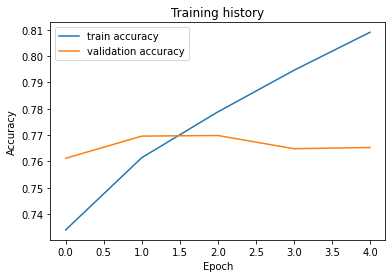

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
#plt.ylim([0, 1])

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/TASME/model/bert-base-multilingual-cased.bin'))

<All keys matched successfully>

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  sentence = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      sentence.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(labels)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return sentence, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [ ]:
class_name = ['Not_offensive' ,'Offensive_Untargetede' ,'Offensive_Targeted_Insult_Group' ,
'Offensive_Targeted_Insult_Individual' ,'not-Tamil' ,'Offensive_Targeted_Insult_Other' ]

In [ ]:
y_pred[1]

tensor(0)

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_name,zero_division=0, digits=4))

                                      precision    recall  f1-score   support

                       Not_offensive     0.8246    0.9511    0.8834      3189
               Offensive_Untargetede     0.3381    0.4484    0.3855       368
     Offensive_Targeted_Insult_Group     0.4000    0.1181    0.1823       288
Offensive_Targeted_Insult_Individual     0.5000    0.0032    0.0063       315
                           not-Tamil     0.8261    0.7125    0.7651       160
     Offensive_Targeted_Insult_Other     0.0000    0.0000    0.0000        71

                            accuracy                         0.7622      4391
                           macro avg     0.4815    0.3722    0.3704      4391
                        weighted avg     0.7194    0.7622    0.7141      4391



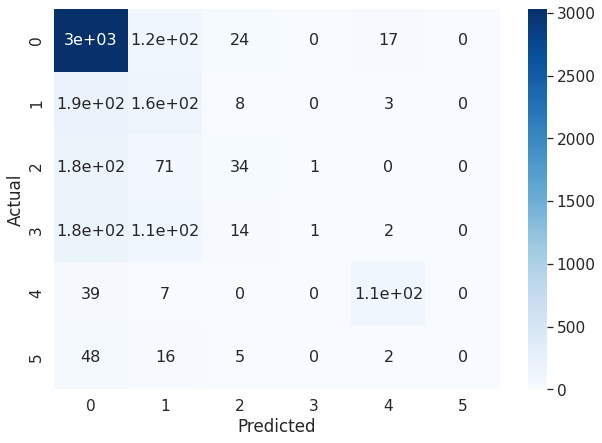

In [ ]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


data = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size